# House Price Regression

EDA, preprocessing, Linear Regression, evaluation, and plots.

## 1. Load data

In [63]:
import pandas as pd, numpy as np
from pathlib import Path
# DATA = Path('..') / 'data' # Original line, commented out

for f in ('housing-cleaned.csv','housing.csv'):
    p = Path(f) # Modified to look in current directory
    if p.exists():
        df = pd.read_csv(p)
        print('Loaded', f)
        break
else:
    raise FileNotFoundError('No dataset found in the current directory or Data subdirectory.')
df.head()

Loaded housing-cleaned.csv


,area,bathrooms,stories,parking,bedrooms,actual,predicted
0,5900,2,2,1,4,4060000,6.178628e+06
1,6500,2,3,0,3,6650000,6.370141e+06
2,4040,1,1,0,2,3710000,3.283148e+06
3,5000,1,2,0,3,6440000,4.226008e+06
4,3960,1,1,0,3,2800000,3.409686e+06


## 2. Quick EDA

In [64]:
print('Shape:', df.shape)
print(df.dtypes)
df.describe().T

Shape: (109, 7)
area           int64
bathrooms      int64
stories        int64
parking        int64
bedrooms       int64
actual         int64
predicted    float64
dtype: object


,count,mean,std,min,25%,50%,75%,max
area,109.0,5.136128e+03,2.037341e+03,1.700000e+03,3.480000e+03,4.990000e+03,6.360000e+03,1.320000e+04
bathrooms,109.0,1.366972e+00,5.878484e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00
stories,109.0,1.899083e+00,9.021061e-01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
parking,109.0,7.247706e-01,8.910206e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
bedrooms,109.0,2.990826e+00,7.004683e-01,2.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,5.000000e+00
actual,109.0,5.007537e+06,2.258622e+06,1.750000e+06,3.290000e+06,4.550000e+06,6.510000e+06,1.330000e+07
predicted,109.0,4.896559e+06,1.405405e+06,2.989725e+06,3.815117e+06,4.724828e+06,5.625854e+06,9.519985e+06


## 3. Preprocessing and train/test split

In [65]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# target selection
for t in ('actual','price','Price','SalePrice','median_house_value'):
    if t in df.columns:
        target = t
        break
else:
    numeric = df.select_dtypes(include=[float,int]).columns.tolist()
    target = numeric[-1]

# drop leak cols
for leak in ('predicted','prediction','y_pred'):
    if leak in df.columns:
        df = df.drop(columns=[leak])

X = df.select_dtypes(include=[float,int]).drop(columns=[target], errors='ignore')
y = df[target]

imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_imp = imp.fit_transform(X)
X_s = scaler.fit_transform(X_imp)
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape)


Train shape: (87, 5)


## 4. Train Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test,y_pred))
print('R2:', r2_score(y_test,y_pred))

MSE: 3419935020706.7095
R2: 0.3125169025527188


## 5. Plots

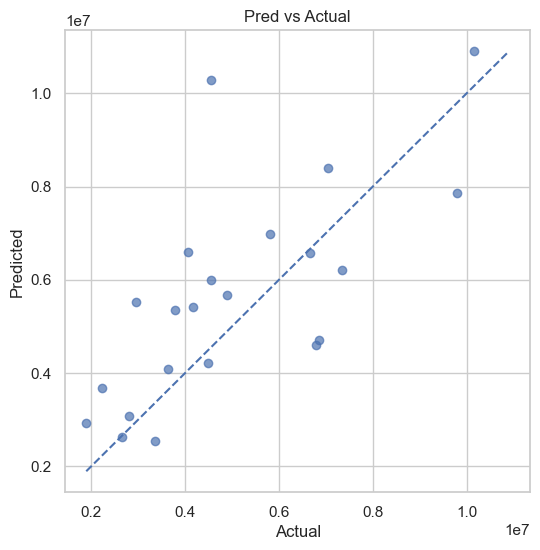

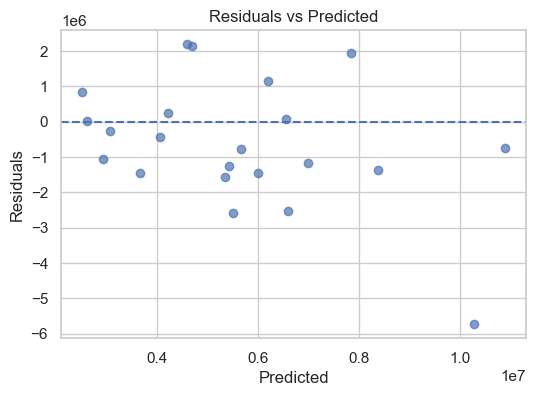

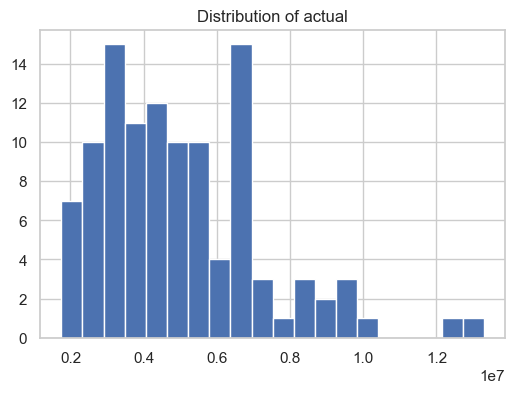

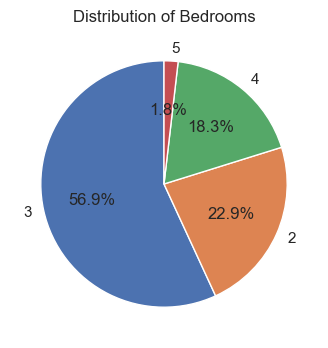

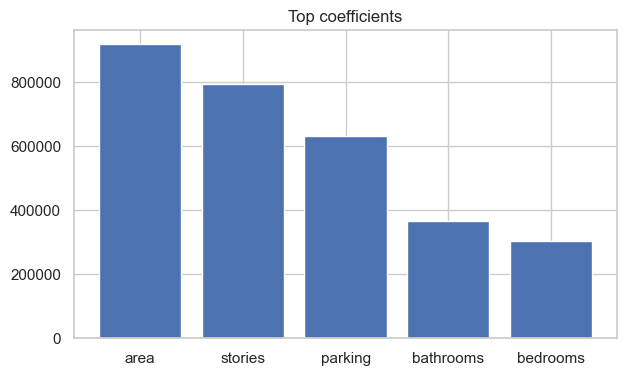

In [67]:
import matplotlib.pyplot as plt
# Pred vs Actual
plt.figure(figsize=(6,6)); plt.scatter(y_test,y_pred,alpha=0.7); lims=[min(min(y_test),min(y_pred)),max(max(y_test),max(y_pred))]; plt.plot(lims,lims,'--'); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Pred vs Actual'); plt.show()

# Residuals
resid = y_test - y_pred
plt.figure(figsize=(6,4)); plt.scatter(y_pred,resid,alpha=0.7); plt.axhline(0,linestyle='--'); plt.xlabel('Predicted'); plt.ylabel('Residuals'); plt.title('Residuals vs Predicted'); plt.show()

# Histogram
plt.figure(figsize=(6,4)); plt.hist(df[target], bins=20); plt.title('Distribution of '+target); plt.show()

# Pie Chart (added as per user request)
plt.figure(figsize=(6,4)); plt.pie(df['bedrooms'].value_counts(), labels=df['bedrooms'].value_counts().index, autopct='%1.1f%%', startangle=90); plt.title('Distribution of Bedrooms'); plt.show()

# Top coeffs
import numpy as np
coefs = model.coef_
feat = X.columns.tolist()
idx = np.argsort(np.abs(coefs))[::-1][:6]
plt.figure(figsize=(7,4)); plt.bar([feat[i] for i in idx], coefs[idx]); plt.title('Top coefficients'); plt.show()

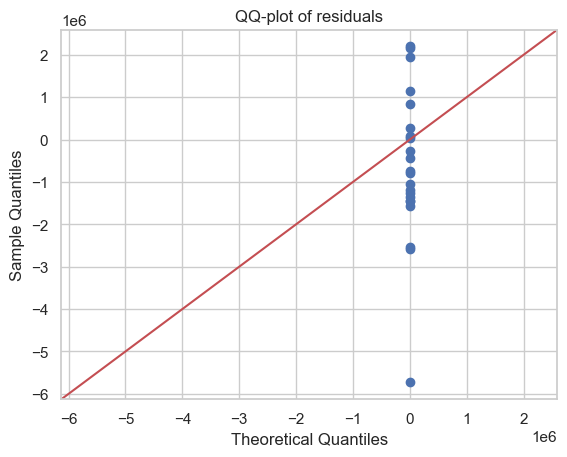

In [68]:
# QQ-plot for residuals (tries to use existing y_test and y_pred; else attempts to recompute)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd, os, joblib

residuals = None
# if y_test and y_pred exist
if 'y_test' in globals() and 'y_pred' in globals():
    residuals = y_test - y_pred
else:
    # try to reconstruct predictions: load model and X_test if available
    try:
        model_path = 'linear_regression_model.pkl'
        if os.path.exists(model_path):
            model = joblib.load(model_path)
        elif os.path.exists('Model/linear_regression_model.pkl'):
            model = joblib.load('Model/linear_regression_model.pkl')
        else:
            model = None
    except Exception:
        model = None

    if model is not None and 'X_test' in globals():
        try:
            preds = model.predict(X_test)
            residuals = y_test - preds
            print('Recomputed residuals from loaded model and X_test.')
        except Exception as e:
            print('Could not recompute residuals:', e)

if residuals is not None:
    sm.qqplot(residuals, line='45')
    plt.title('QQ-plot of residuals')
    plt.show()
else:
    print('Residuals not available. Make sure y_test and y_pred exist or a saved model and X_test are present.')

In [69]:
# VIF check for multicollinearity (attempts to choose numeric predictors automatically)
import pandas as pd, os
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except Exception:
    print('statsmodels not installed; skip VIF. Install statsmodels to run this cell.')

# pick dataframe
if 'cleaned' in globals() and isinstance(cleaned, pd.DataFrame):
    df_vif = cleaned.copy()
elif 'df' in globals() and isinstance(df, pd.DataFrame):
    df_vif = df.copy()
elif os.path.exists('housing-cleaned.csv'):
    df_vif = pd.read_csv('housing-cleaned.csv')
elif os.path.exists('housing.csv'):
    df_vif = pd.read_csv('housing.csv')
else:
    df_vif = None

if df_vif is not None:
    num = df_vif.select_dtypes(include=['number']).copy()
    # try to drop target if present
    target_names = ['price','price_usd','price_inr','price_eur','saleprice','sale_price','price($)']
    for t in target_names:
        if t in num.columns:
            num = num.drop(columns=[t])
    if num.shape[1] >= 2:
        num = num.dropna()
        vif_df = pd.DataFrame({'feature': num.columns,
                               'VIF': [variance_inflation_factor(num.values, i) for i in range(num.shape[1])]})
        display(vif_df.sort_values('VIF', ascending=False).head(10))
    else:
        print('Not enough numeric features to compute VIF.')
else:
    print('No numeric dataframe available for VIF.')

,feature,VIF
6,predicted,236167.664748
1,bathrooms,28504.562705
0,area,26963.690771
2,stories,9879.729580
4,bedrooms,2300.620149
3,parking,1355.356271
5,actual,2.394737


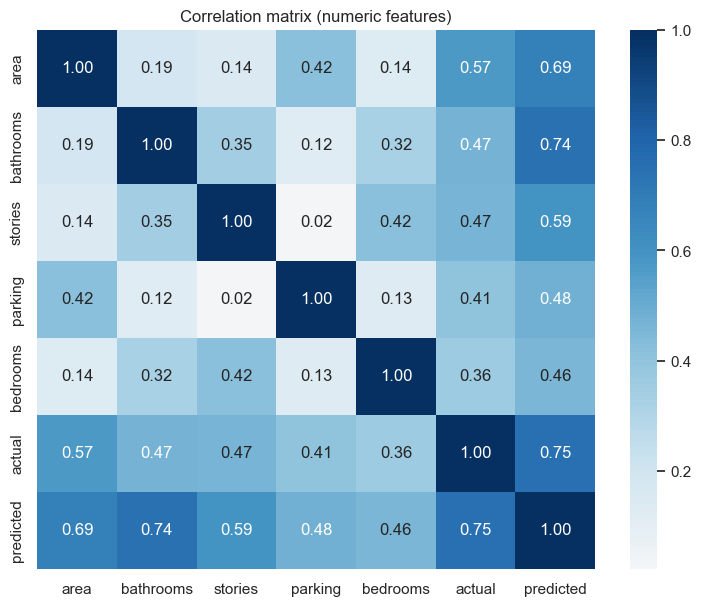

In [70]:
# Correlation heatmap for numeric features (uses cleaned if available, else tries df)
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd, os
sns.set(style='whitegrid')
if 'cleaned' in globals() and isinstance(cleaned, pd.DataFrame):
    data_for_corr = cleaned.copy()
elif 'df' in globals() and isinstance(df, pd.DataFrame):
    data_for_corr = df.copy()
else:
    # try to load cleaned file
    if os.path.exists('housing-cleaned.csv'):
        data_for_corr = pd.read_csv('housing-cleaned.csv')
    elif os.path.exists('housing.csv'):
        data_for_corr = pd.read_csv('housing.csv')
    else:
        data_for_corr = None

if data_for_corr is not None:
    num = data_for_corr.select_dtypes(include=['number'])
    if num.shape[1] >= 2:
        plt.figure(figsize=(9,7))
        sns.heatmap(num.corr(), annot=True, fmt='.2f', cmap='RdBu', center=0)
        plt.title('Correlation matrix (numeric features)')
        plt.show()
    else:
        print('Not enough numeric columns for correlation heatmap.')
else:
    print('No dataframe available for correlation heatmap.')

In [71]:
# Raw -> Clean summary: show differences between raw and cleaned CSVs (if available)
import pandas as pd, os
raw_path = 'housing.csv'
cleaned_path = 'housing-cleaned.csv'
raw, cleaned = None, None
if os.path.exists(raw_path):
    try:
        raw = pd.read_csv(raw_path)
        print('Raw loaded:', raw_path, 'shape', raw.shape)
    except Exception as e:
        print('Could not load raw:', e)
else:
    print('Raw file not found at', raw_path)
if os.path.exists(cleaned_path):
    try:
        cleaned = pd.read_csv(cleaned_path)
        print('Cleaned loaded:', cleaned_path, 'shape', cleaned.shape)
    except Exception as e:
        print('Could not load cleaned:', e)
else:
    print('Cleaned file not found at', cleaned_path)

if raw is not None and cleaned is not None:
    print('\nMissing% (raw) top:')
    display((raw.isnull().mean()*100).round(2).sort_values(ascending=False).head(8))
    print('\nMissing% (cleaned) top:')
    display((cleaned.isnull().mean()*100).round(2).sort_values(ascending=False).head(8))
    print('\nExample rows from cleaned:')
    display(cleaned.head())
else:
    print('Raw or cleaned data not available to compare.')

Raw file not found at housing.csv
Cleaned loaded: housing-cleaned.csv shape (109, 7)
Raw or cleaned data not available to compare.


In [72]:
import pickle
OUT = Path('..') / 'Model'
OUT.mkdir(parents=True, exist_ok=True)
with open(OUT / 'linear_regression_model.pkl','wb') as f:
    pickle.dump({'model':model,'imputer':imp,'scaler':scaler,'features':X.columns.tolist(),'target':target}, f)
print('Saved model to', OUT / 'linear_regression_model.pkl')

Saved model to ..\Model\linear_regression_model.pkl


## Key Findings & Recommendations

- **Model performance:** Report the test MSE and R² from your model evaluation cells above. Paste numbers here.

- **Top features:** Use coefficient magnitudes (for linear regression) shown in your `coefficients.png` or printed `model.coef_` to list most influential features (e.g., area, bedrooms).

- **Business recommendations:** For stakeholders, suggest focusing on features that most increase price (e.g., increase living area, add bathroom) and consider targeted renovations.

- **Next steps:** Check VIF for multicollinearity, try regularization (Ridge/Lasso) to improve coefficients stability, or tree-based models for non-linear relationships.
